In [80]:
import numpy as np
import xarray as xr
import pygmt

In [81]:
with open('real_input.txt', 'r') as fh:
    lines = [line.strip() for line in fh.readlines()]

letter_values = {letter: value for value, letter in enumerate('abcdefghijklmnopqrstuvwxyz')}
    
numx = len(lines[0])
numy = len(lines)
grid = np.zeros((numy, numx))

for x in np.arange(numx):
    for y in np.arange(numy-1, -1, -1):
        letter = lines[y][x]
        if letter == 'S':
            grid[y,x] = 0
            start = (y, x)
        elif letter == 'E':
            grid[y,x] = 26
            end = (y, x)
        elif letter in letter_values.keys():
            grid[y,x] = letter_values[letter]
        else:
            print("Invalid letter: ", letter)
    

In [82]:
def valid_steps(grid, start):
    steps = []
    directions = [[0, 1], [-1, 0], [0, -1], [1, 0]]
    for direction in directions:
        new_position = tuple(start + np.array(direction))
        if new_position[0] < 0 or new_position[0] > numy-1 or new_position[1] < 0 or new_position[1] > numx-1:
            # not in grid
            continue
        elif grid[tuple(new_position)] > grid[tuple(start)] + 1:
            # too steep to climb without climbing gear
            continue
        else:
            steps.append(tuple(new_position))
    return steps


def check(grid, current):
    global visited_grid, distance_grid, idx_y_grid, idx_x_grid
    valid_steps_found = valid_steps(grid, current)
    for step in valid_steps_found:
        if distance_grid[current] + 1 < distance_grid[step]: # Update shortest path to this point
            distance_grid[step] = distance_grid[current] + 1 # Add one step
            idx_y_grid[step] = current[0] # Keep information about shortest way to get here in these two arrays of grid-indices
            idx_x_grid[step] = current[1]
    visited_grid[current] = 1

def find_shortest_path(grid, start, end):
    global distance_grid, visited_grid, idx_x_grid, idx_y_grid
    
    distance_grid = np.zeros((numy, numx))
    distance_grid[:,:] = 1e33
    visited_grid = np.zeros((numy, numx))
    visited_grid[:,:] = 0
    idx_x_grid = np.zeros((numy, numx), dtype='int')
    idx_x_grid[:,:] = -1
    idx_y_grid = np.zeros((numy, numx), dtype='int')
    idx_y_grid[:,:] = -1

    distance_grid[start] = 0
    idx_y_grid[start] = start[0]
    idx_x_grid[start] = start[1]
    
    current = start
    finished = False
    while True:
        if finished:
            break
        check(grid, current)
        minval = np.where(visited_grid<1, distance_grid, 1e34).min()
        if minval > 1e29:
            return 1e33
        result = np.where(distance_grid == minval)
        min_indices = list(zip(result[0], result[1]))
        for current in min_indices:
            check(grid, current)
            if np.all(np.array(current) == np.array(end)):
                finished = True


    path = []
    current = end
    while current != start:
        path.append(list(current))
        current = (idx_y_grid[current], idx_x_grid[current])

    valid_path = np.array(path)
    return np.shape(valid_path)[0]

In [83]:
start

(20, 0)

In [84]:
find_shortest_path(grid, start, end)

484

In [73]:
lengths = []
start_position_grid = np.where(grid==0)
start_positions = list(zip(start_position_grid[0], start_position_grid[1]))
for i, item in enumerate(start_positions):
    length = find_shortest_path(grid, item, end)
    lengths.append(length)

In [74]:
np.array(lengths).min()

478.0

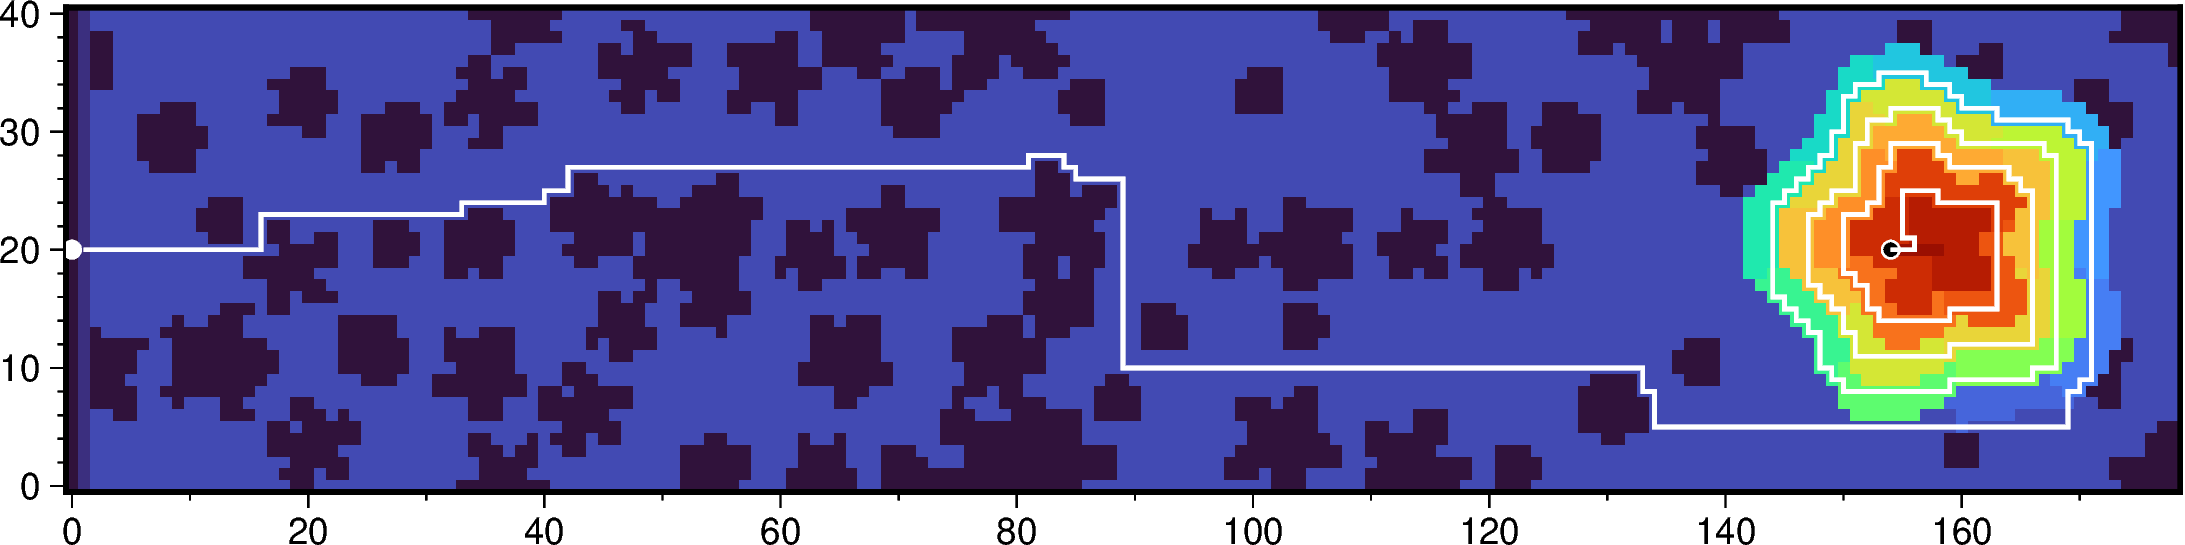

In [85]:
proj = f"X{numx/10}c/{numy/10}c"
xrgrid = xr.DataArray(grid)
xrgrid.gmt.registration = 1
xrgrid.gmt.gtype = 0
fig = pygmt.Figure()
fig.grdimage(xrgrid, cmap='turbo', frame=True, projection=proj, region=[-0.5,numx-0.5,-0.5,numy-0.5])
fig.plot(x=start[1], y=start[0], style='c0.15c', pen='0.5p,white', color='white')
fig.plot(x=end[1], y=end[0], style='c0.15c', pen='0.5p,white', color='black')
fig.plot(x=valid_path[:,1], y=valid_path[:,0], pen='1p,white')
fig.show(width=1400)
fig.savefig("actual_shortest_path.png")

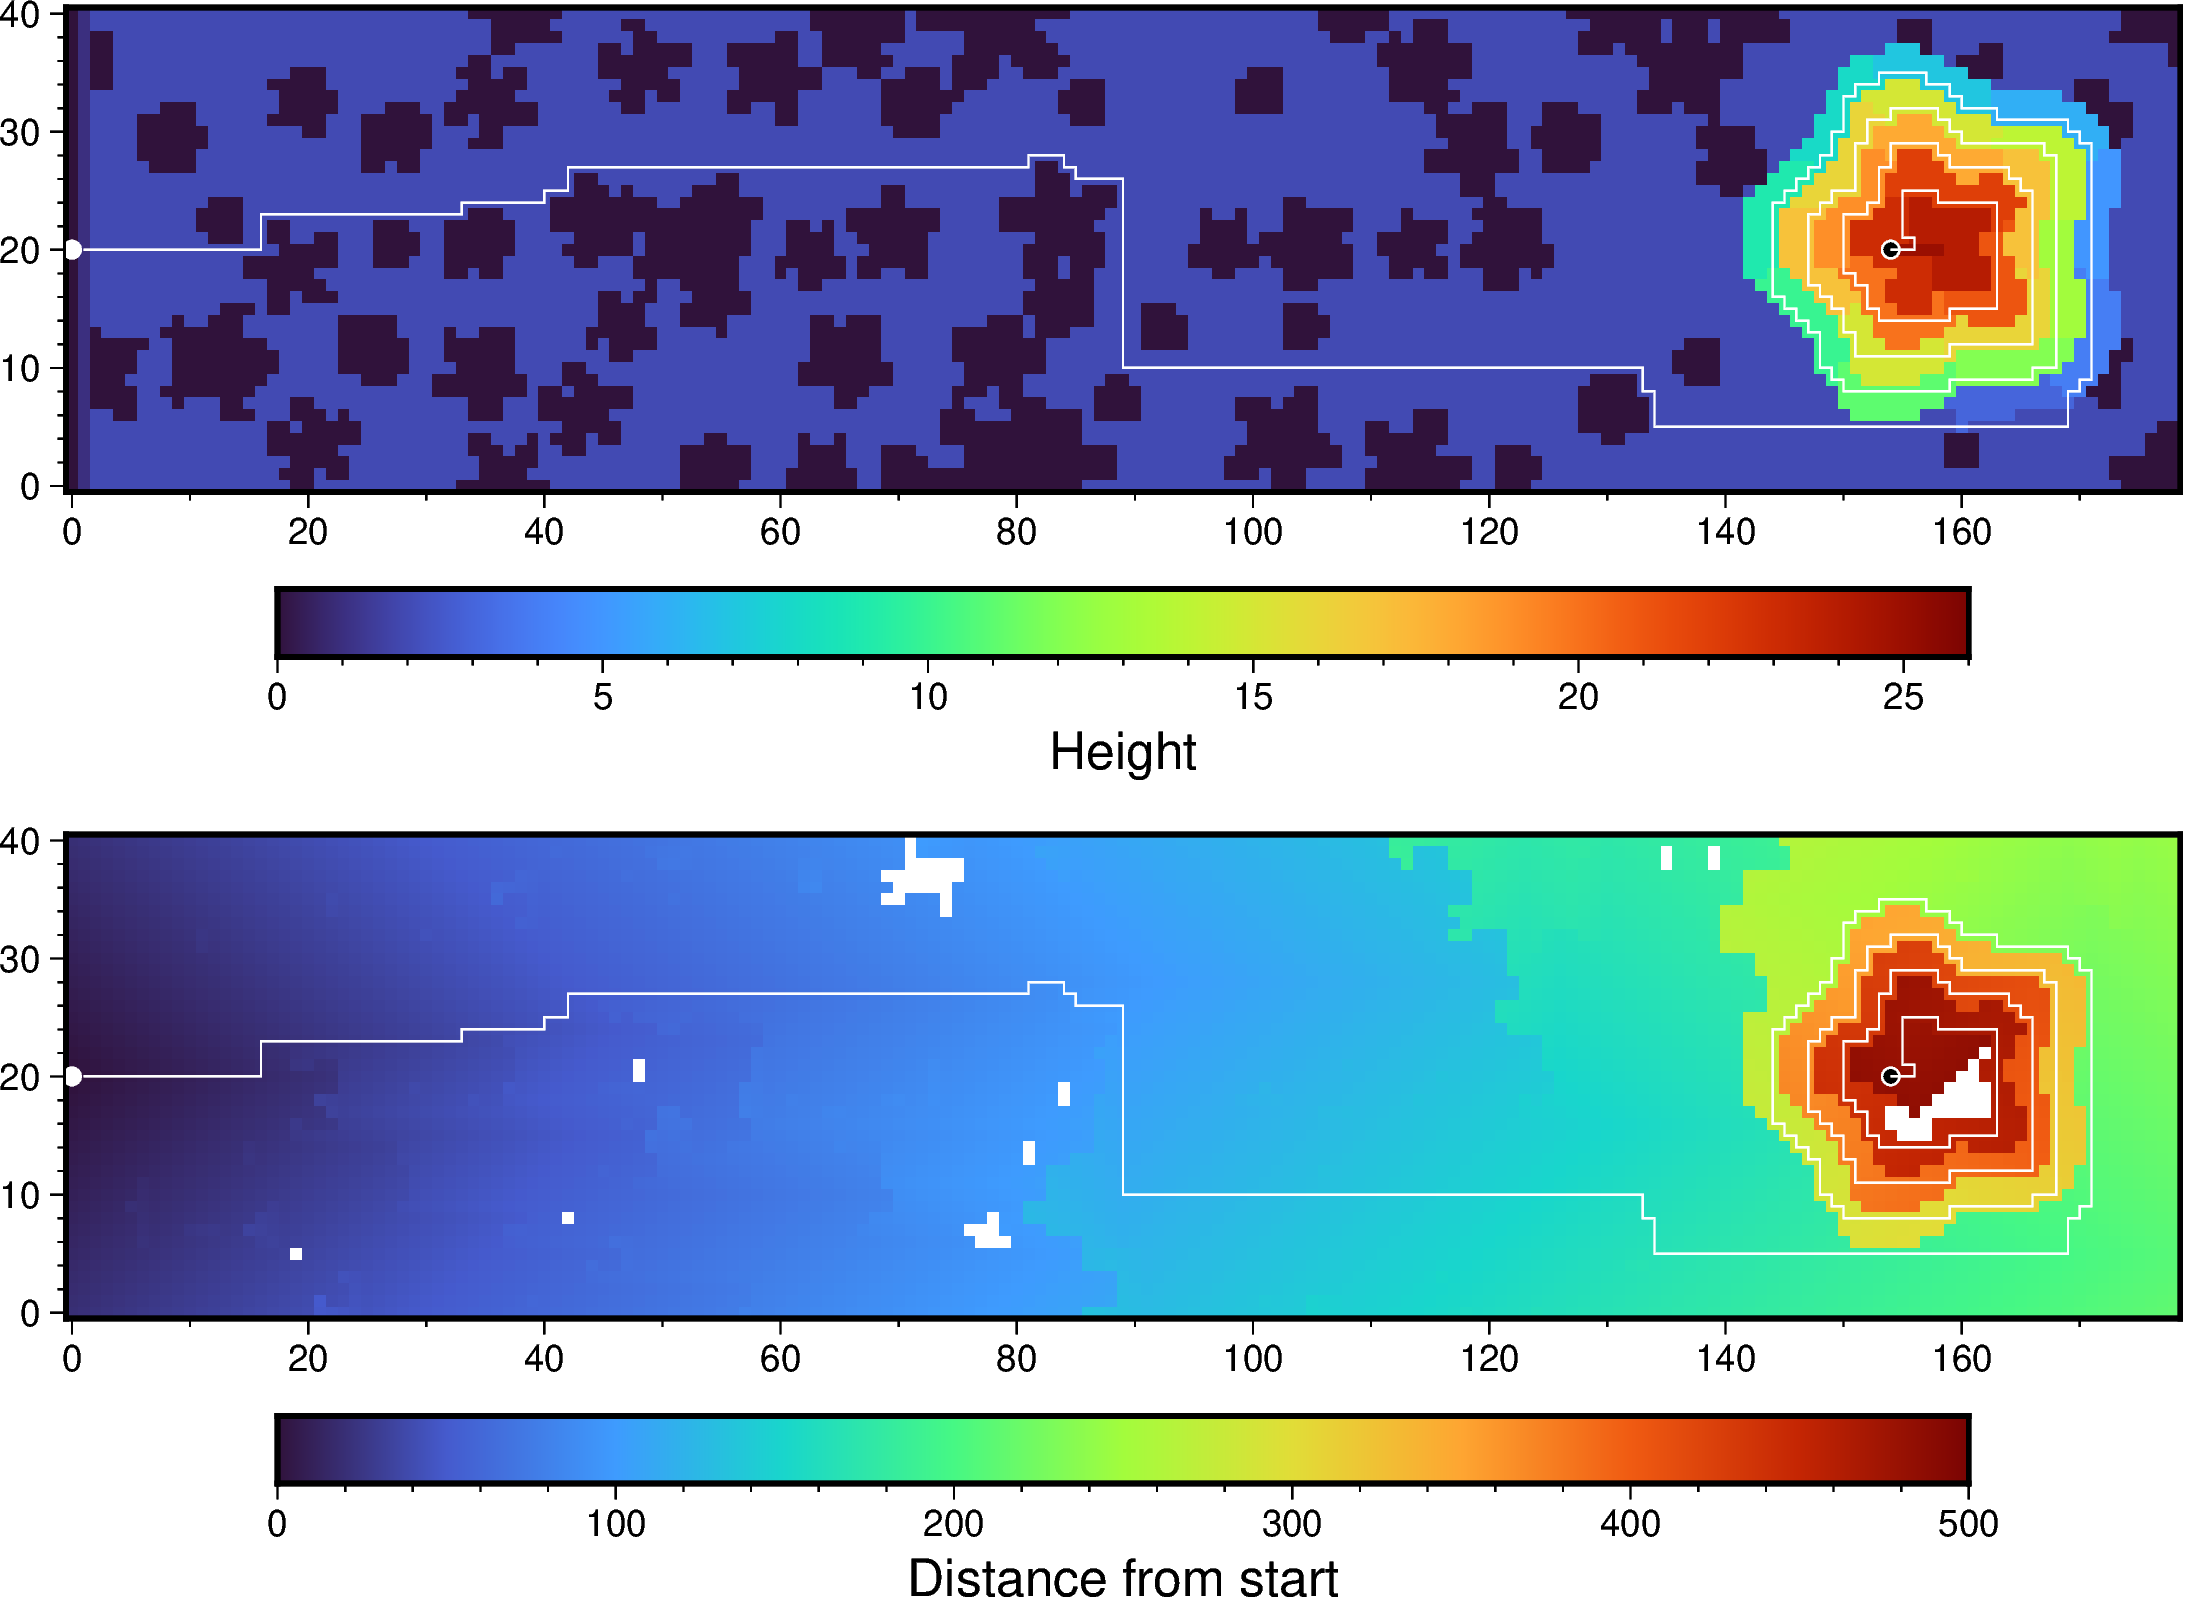

In [97]:
proj = f"X{numx/10}c/{numy/10}c"
xrgrid = xr.DataArray(distance_grid)
xrgrid.gmt.registration = 1
xrgrid.gmt.gtype = 0
fig = pygmt.Figure()
pygmt.makecpt(cmap='turbo', series=[0,500,50], continuous=True)
fig.grdimage(xrgrid, frame=True, projection=proj)
fig.plot(x=start[1], y=start[0], style='c0.15c', pen='0.5p,white', color='white')
fig.plot(x=end[1], y=end[0], style='c0.15c', pen='0.5p,white', color='black')
fig.plot(x=valid_path[:,1], y=valid_path[:,0], pen='0.5p,white')
fig.colorbar(frame='+l"Distance from start"')
xrgrid = xr.DataArray(grid)
xrgrid.gmt.registration = 1
xrgrid.gmt.gtype = 0
fig.grdimage(xrgrid, cmap='turbo', frame=True, projection=proj, region=[-0.5,numx-0.5,-0.5,numy-0.5], yshift='7c')
fig.plot(x=start[1], y=start[0], style='c0.15c', pen='0.5p,white', color='white')
fig.plot(x=end[1], y=end[0], style='c0.15c', pen='0.5p,white', color='black')
fig.plot(x=valid_path[:,1], y=valid_path[:,0], pen='0.5p,white')
fig.colorbar(frame='+l"Height"')
fig.savefig("actual_shortest_path.png")
fig.show(width=1000)

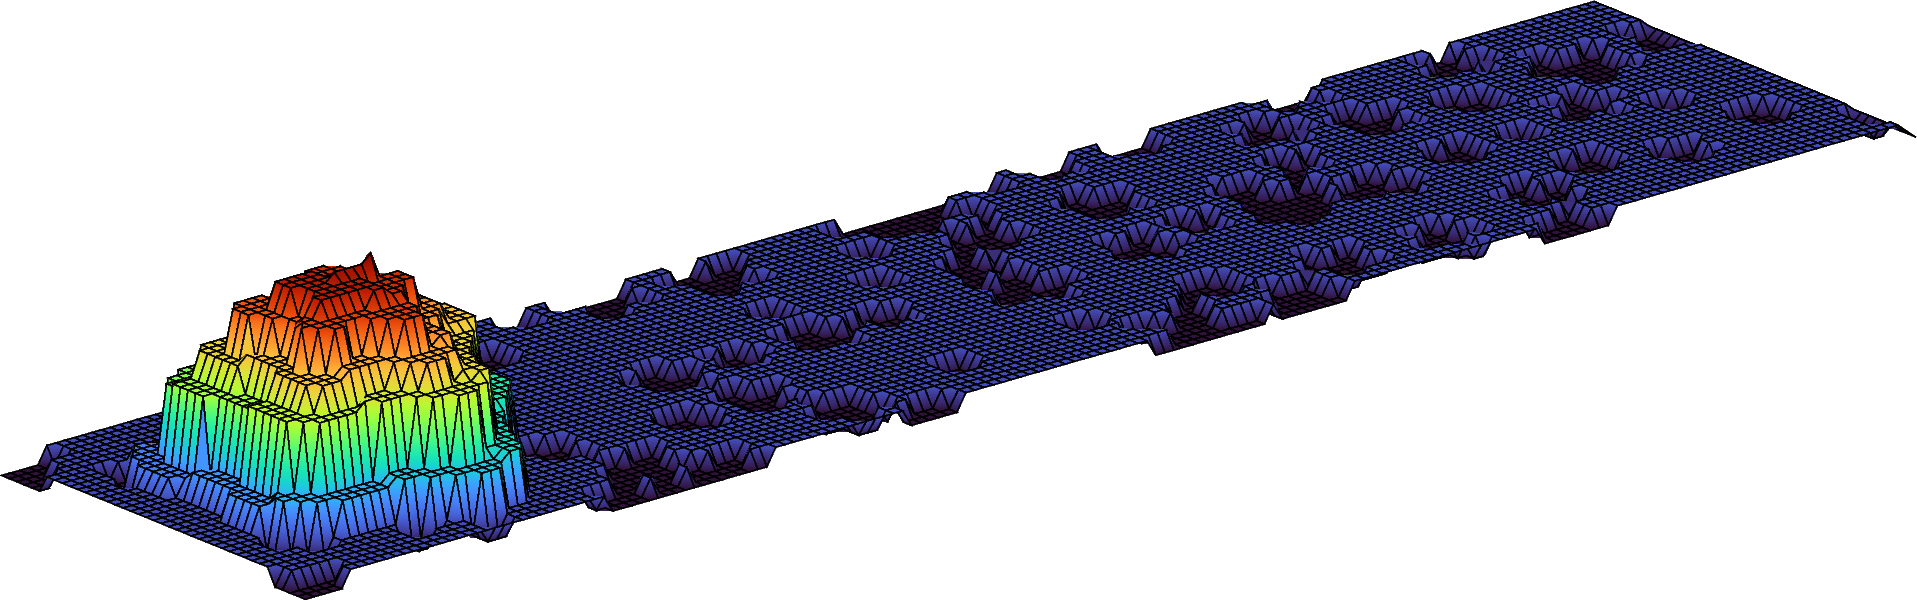

In [128]:
xrgrid = xr.DataArray(grid)
xrgrid.gmt.registration = 1
xrgrid.gmt.gtype = 0
fig = pygmt.Figure()
fig.grdview(grid=xrgrid, drapegrid=xrgrid, perspective=[40, 20], zsize="2c", surftype='sm', cmap='turbo', projection=proj, region=[-0.5,numx-0.5,-0.5,numy-0.5])
# fig.plot(yshift='-3c', x=start[1], y=start[0], style='c0.15c', pen='0.5p,black', color='white', frame=True, perspective=[210, 30])
# fig.plot(x=end[1], y=end[0], style='c0.15c', pen='0.5p,gray', color='black', perspective=[210,30])
# fig.grdimage(grid=xrgrid, perspective=[210, 30], cmap='turbo', frame=True, projection=proj, region=[-0.5,numx-0.5,-0.5,numy-0.5])
# fig.plot(x=valid_path[:,1], y=valid_path[:,0], pen='1p,white', perspective=[210, 30])
fig.show(width=1400)
fig.savefig("shortest_path_3d.png")

In [123]:
import numpngw

In [129]:
grid

array([[0., 1., 2., ..., 0., 0., 0.],
       [0., 1., 2., ..., 0., 0., 0.],
       [0., 1., 2., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 2., ..., 0., 0., 0.],
       [0., 1., 2., ..., 0., 0., 0.]])

In [132]:
numpngw.write_png('grid.png', np.array(grid, dtype='uint8'), bitdepth=8)

In [133]:
!open grid.png

In [134]:
np.shape(grid)

(41, 179)